# CNN Model

This code is an adaptation of the CNN model provided by Professor Jorge Henriques in the course slides, the CNN model developed for another course (available at https://github.com/leosousa200/RetinopathyAlgorithm), a guide to multi-input CNN provided by Keras (available at https://keras.io/guides/functional_api/) and a CNN model available on Kaggle (at https://www.kaggle.com/code/vishwasgpai/guide-for-creating-cnn-model-using-csv-file/notebook).

### Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Concatenate

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Data Preprocessing and Organization

In [37]:
numeric = pd.read_csv("COVID_numerics.csv").values
images  = pd.read_csv("COVID_IMG.csv",header=None).values # avoids ignoring first line!

X_num = numeric[:,0:8] # 8 columns (GENDER,AGE,MARITAL STATUS,VACINATION,RESPIRATION CLASS,HEART RATE,SYSTOLIC BLOOD PRESSURE,TEMPERATURE)
T = numeric[:,8] # Target
X_img = images[:,:] # each line represents a 21x21 image

# RULE: IF breathing difficulty >= moderate AND Temperature > 37.8 THEN Stay at hospital (T=1)
T[(numeric[:, 4]>=2) & (numeric[:, 7]>=37.8)] = 1

t0 = np.sum(T==0)
t1 = np.sum(T==1)
print(f"Number of cases with T=0: {t0}")
print(f"Number of cases with T=1: {t1}")

Number of cases with T=0: 359
Number of cases with T=1: 241


### Reshape Image Data (21x21)

In [38]:
X_img = X_img.reshape(X_img.shape[0],21,21,1) # resize images into 21x21x1

### Train-Test Split

In [39]:
X_img_train, X_img_test, X_num_train, X_num_test, T_train, T_test = train_test_split(X_img, X_num, T, test_size=0.3, random_state=42)

### Model

In [40]:
numeric_input = Input(shape=(8,))
image_input = Input(shape=(21,21,1))

# CNN Path Only for the Images
x_img = Conv2D(64, (3, 3), activation='relu')(image_input)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Conv2D(32, (3, 3), activation='relu')(x_img)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Flatten()(x_img)

# MLP Path Only for Numerical Data
x_num = Dense(64, activation='relu')(numeric_input)

# Concatenate Outputs
concatenated = Concatenate()([x_img, x_num])

# Final Output Dense Layer
output = Dense(1,activation='sigmoid')(concatenated) # this is a binary classification problem, so we can use the Sigmoid activation function

model = Model(inputs=[image_input,numeric_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 21, 21, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 19, 19,    │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 9, 9, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 3, 3, 32)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 288)       │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        576 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 352)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        353 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

Epoch 1/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7662 - loss: 0.5330
Epoch 2/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7622 - loss: 0.5173
Epoch 3/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7379 - loss: 0.5287
Epoch 4/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7328 - loss: 0.5271
Epoch 5/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7585 - loss: 0.4866
Epoch 6/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7657 - loss: 0.4825
Epoch 7/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7569 - loss: 0.5033
Epoch 8/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7467 - loss: 0.5034
Epoch 9/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7517 - loss: 0.4972
Epoch 10/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7202 - loss: 0.5462
Epoch 11/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7295 - loss: 0.5352
Epoch 12/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7371 - loss: 0.5142
L

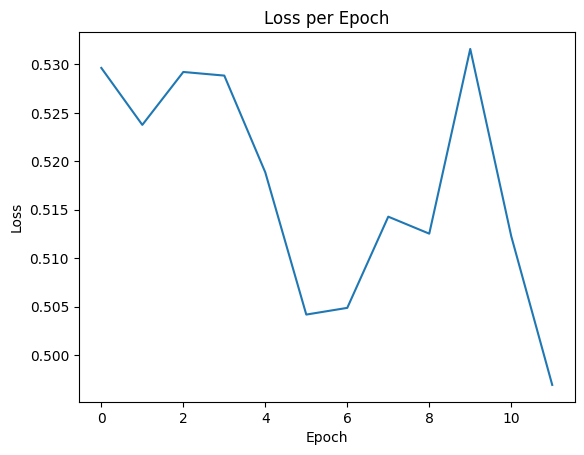

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [44]:
history = model.fit([X_img_train, X_num_train], T_train, epochs=12, batch_size=64)
print("Loss: ", history.history['loss'])

plt.plot(history.history['loss'])
plt.title('Loss per Epoch'), plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

train = model.predict([X_img_train, X_num_train]).round()

print(classification_report(T_train,train))

### Test Model

In [42]:
Ytest = model.predict([X_img_test, X_num_test]).round()
scores = model.evaluate([X_img_test, X_num_test], T_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Baseline Error: 31.11%


### Evaluate Model

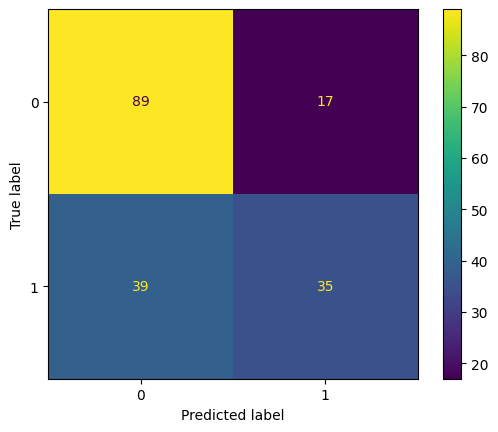

              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76       106
         1.0       0.67      0.47      0.56        74

    accuracy                           0.69       180
   macro avg       0.68      0.66      0.66       180
weighted avg       0.69      0.69      0.68       180



In [43]:
cm = confusion_matrix(T_test, Ytest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(T_test,Ytest))